## Data Collection Module

#### Objective

Build a unified, reusable module that collects trending topics, articles, and discussions from 4 diverese data sources
1. Reddit API (JSON): Real-time discussions & user sentiment
2. Hacker News API (REST Firebase style): Tech + startup-focused headlines
3. RSS Feeds (XML): Blog/ news aggregation from top publishers
4. ~~Google Trends (CSS/ structured): Search interest trends from Google~~
5. Google Custom Search API
6. Youtube Data API
7. News API

#### Activities

- Working with JSON, XML, REST APIs
- Rate limiting & scraping ethics (avoid banks and stay TOS-compliant)
- Clearning, normalizing, storing data (prepare data for NLP and analysis)
- API Key management (for Google Trends)

In [1]:
import requests
import pandas as pd
import feedparser 
from bs4 import BeautifulSoup
from pytrends.request import TrendReq
import os
from dotenv import load_dotenv
from pathlib import Path
from datetime import datetime, timezone
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

#### Load environment variables first

In [2]:
# load .env file from the parent folder
env_path = Path("..")/".env"
load_dotenv(dotenv_path = env_path)

True

#### Fetch Reddit hot posts

In [3]:
def fetch_reddit_posts(subreddit="marketing", limit=10):
    url = f"https://www.reddit.com/r/{subreddit}/hot.json?limit={limit}"
    headers = {"User-Agent": "ContentMarketingAgent/0.1"}

    response = requests.get(url, headers=headers)
    data = response.json()

    posts = []
    for post in data["data"]["children"]:
        published_at = pd.to_datetime((post["data"]["created_utc"]), unit="s", utc=True)
        posts.append(
            {
                "title": post["data"]["title"],
                "score": post["data"]["score"],
                "url": post["data"]["url"],
                "publishedAt": published_at.floor("s"), # drop micro-seconds
                "source": "Reddit"
            }
        )

    return pd.DataFrame(posts)

In [4]:
reddit_df = fetch_reddit_posts("contentmarketing", limit=10)
reddit_df.head()

,title,score,url,publishedAt,source
0,Struggling to Get Clients Even Though You’re G...,3,https://www.reddit.com/r/ContentMarketing/comm...,2025-02-14 10:05:05+00:00,Reddit
1,"30% off code for Blaze ai – use ""30OFF""",1,https://www.reddit.com/r/ContentMarketing/comm...,2025-07-08 22:11:13+00:00,Reddit
2,"I'm an expert affilliate marketer, and I can h...",1,https://i.redd.it/qpyqy1700qbf1.jpeg,2025-07-08 21:42:11+00:00,Reddit
3,Would an extra 1K a month benefit you?,1,https://www.tumblr.com/the-front-porch-deals-n...,2025-07-08 16:35:08+00:00,Reddit
4,50k Followers on Instagram in 2 years - Update,2,https://www.reddit.com/r/ContentMarketing/comm...,2025-07-08 12:27:08+00:00,Reddit


In [5]:
reddit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   title        11 non-null     object             
 1   score        11 non-null     int64              
 2   url          11 non-null     object             
 3   publishedAt  11 non-null     datetime64[ns, UTC]
 4   source       11 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(1), object(3)
memory usage: 568.0+ bytes


#### Hacker News API - Fetch Top Stories

In [3]:
def fetch_hackernews_top(n=10):
    base = "https://hacker-news.firebaseio.com/v0"
    headers = {"User-Agent": "ContentMarketingAgent/0.1"}
    
    response = requests.get(f"{base}/topstories.json", headers=headers)
    top_stories = response.json()[:n]

    stories = []

    for story_id in top_stories:
        story = requests.get(f"{base}/item/{story_id}.json").json()

        if story and "title" in story:
            published_at = pd.to_datetime(story.get("time", 0), unit="s", utc=True)
            stories.append(
                {
                    "title": story["title"],
                    "score:": story.get("score", 0),
                    "url": story.get("url", ""),
                    "publishedAt": published_at.floor("s"), #drop micro-seconds
                    "source": "Hacker News"
                }
            )

    return pd.DataFrame(stories)

In [4]:
hn_df = fetch_hackernews_top(10)
hn_df.head()

,title,score:,url,publishedAt,source
0,Bill Atkinson's Psychedelic User Interface,168,https://patternproject.substack.com/p/from-the...,2025-07-11 11:03:59+00:00,Hacker News
1,At Least 13 People Died by Suicide Amid U.K. P...,248,https://www.nytimes.com/2025/07/10/world/europ...,2025-07-11 11:56:19+00:00,Hacker News
2,"Overtourism in Japan, and how it hurts small b...",65,https://craigmod.com/ridgeline/210/,2025-07-11 13:07:03+00:00,Hacker News
3,AI Agent Benchmarks Are Broken,76,https://ddkang.substack.com/p/ai-agent-benchma...,2025-07-11 13:06:32+00:00,Hacker News
4,Recovering from AI Addiction,157,https://internetaddictsanonymous.org/internet-...,2025-07-11 11:28:11+00:00,Hacker News


In [8]:
hn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   title        10 non-null     object             
 1   score:       10 non-null     int64              
 2   url          10 non-null     object             
 3   publishedAt  10 non-null     datetime64[ns, UTC]
 4   source       10 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(1), object(3)
memory usage: 528.0+ bytes


#### RSS Feeds - Blog & News Aggregation

In [9]:
def fetch_rss_articles(rss_url, limit=10):
    feed = feedparser.parse(rss_url)
    articles = []

    for entry in feed.entries[:limit]:

        published_at = pd.to_datetime(entry.get("published", ""), errors="coerce", utc=True)        
        articles.append(
            {
                "title": entry.get("title", ""),
                "url": entry.get("link", ""),
                "publishedAt": published_at.floor("s"), # drop micro-seconds
                "summary": BeautifulSoup(entry.get("summary", ""), "html.parser").get_text(),
                "source": "RSS"
            }
        )

    return pd.DataFrame(articles)

In [10]:
rss_df = fetch_rss_articles("https://feeds.feedburner.com/TechCrunch/", limit=10)
rss_df.head()

,title,url,publishedAt,summary,source
0,Top 10 AI Tools That Will Transform Your Conte...,https://techncruncher.blogspot.com/2025/01/top...,2025-01-02 09:26:00+00:00,Looking to level up your content creation game...,RSS
1,"LimeWire AI Studio Review 2023: Details, Prici...",https://techncruncher.blogspot.com/2023/12/lim...,2023-12-12 16:10:00+00:00,In the rapidly advancing landscape of AI tech...,RSS
2,Top 10 AI Tools in 2023 That Will Make Your Li...,https://techncruncher.blogspot.com/2023/01/top...,2023-01-25 19:52:00+00:00,"In this article, we explore the top 10 AI too...",RSS
3,Top 10 AI Content Generator & Writer Tools in ...,https://techncruncher.blogspot.com/2022/11/top...,2022-11-15 08:58:00+00:00,Are you looking for a way to create content th...,RSS
4,Beginner Guide to CJ Affiliate (Commission Jun...,https://techncruncher.blogspot.com/2022/09/cj-...,2022-09-10 08:57:00+00:00,Image by vectorjuice on FreepikIn this CJ Affi...,RSS


In [11]:
rss_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   title        10 non-null     object             
 1   url          10 non-null     object             
 2   publishedAt  10 non-null     datetime64[ns, UTC]
 3   summary      10 non-null     object             
 4   source       10 non-null     object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 528.0+ bytes


#### Google Custom Search API

In [12]:
def search_google(query="content marketing", num_results=5):
    url = f"https://www.googleapis.com/customsearch/v1"
    
    GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
    GOOGLE_CSE_ID = os.getenv("GOOGLE_CSE_ID")
                               
    params = {
        "key": GOOGLE_API_KEY,
        "cx": GOOGLE_CSE_ID,
        "q": query,
        "num": num_results
    }

    results = []
    
    response = requests.get(url, params=params)
    items = response.json().get("items", [])

    now = pd.to_datetime(datetime.now(timezone.utc)).floor("s")
    
    for item in items:
        results.append(
            {
                "title": item["title"],
                "link": item["link"],
                "snippet": item.get("snippet", ""),
                'publishedAt': now,  # fallback (Google doesn’t return pub date),
                "source": "Google Search"
            }
        )

    return pd.DataFrame(results)

In [13]:
google_results_df = search_google("AI in content marketing", 5)
google_results_df.head()

,title,link,snippet,publishedAt,source
0,AI in content marketing: How creators and mark...,https://blog.hubspot.com/marketing/ai-in-conte...,"Jun 17, 2025 ... AI in content marketing invol...",2025-07-08 23:50:57+00:00,Google Search
1,AI in Marketing recent news | Content Marketin...,https://contentmarketinginstitute.com/strategy...,Explore the latest news and expert commentary ...,2025-07-08 23:50:57+00:00,Google Search
2,A Complete Guide to Adopting AI in Content Mar...,https://sproutsocial.com/insights/ai-content-m...,"Jan 29, 2025 ... AI helps you distribute conte...",2025-07-08 23:50:57+00:00,Google Search
3,AI tools for content marketing : r/marketing,https://www.reddit.com/r/marketing/comments/17...,"Oct 31, 2023 ... Check out Spreadsheet Daddy, ...",2025-07-08 23:50:57+00:00,Google Search
4,Artificial Intelligence And The Future Of Cont...,https://www.forbes.com/councils/forbescommunic...,"Dec 22, 2023 ... One of the most significant b...",2025-07-08 23:50:57+00:00,Google Search


In [14]:
google_results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   title        5 non-null      object             
 1   link         5 non-null      object             
 2   snippet      5 non-null      object             
 3   publishedAt  5 non-null      datetime64[ns, UTC]
 4   source       5 non-null      object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 328.0+ bytes


#### YouTube Data API

In [15]:
def search_youtube(query="AI marketing", max_results=5):
    
    url = f"https://www.googleapis.com/youtube/v3/search"
    
    YOUTUBE_API_KEY = os.getenv("YOUTUBE_API_KEY")
    
    params = {
        'key': YOUTUBE_API_KEY,
        'part': 'snippet',
        'q': query,
        'type': 'video',
        'maxResults': max_results
    }

    results = []

    response = requests.get(url, params=params)
    items = response.json().get("items", [])
    
    for item in items:
        published_at = pd.to_datetime(item["snippet"]["publishedAt"], errors="coerce", utc=True)
        results.append(
            {
                "title": item["snippet"]["title"],
                "channel": item["snippet"]["channelTitle"],
                "url": f"https://youtube.com/watch?v={item['id']['videoId']}", 
                "publishedAt": published_at.floor("s"), # drop micro-seconds
                "source": "YouTube"
            }        
        )

    return pd.DataFrame(results)

In [16]:
youtube_df = search_youtube("AI marketing tools", 5)
youtube_df.head()


,title,channel,url,publishedAt,source
0,7 Best AI Marketing Tools,Learn With Shopify,https://youtube.com/watch?v=JB7vXQ_gyAw,2025-01-05 14:00:18+00:00,YouTube
1,Top 10 AI Tools For Digital Marketing in 2025,Jordan Platten Extra,https://youtube.com/watch?v=n8zKsFoo2FE,2023-02-01 19:19:46+00:00,YouTube
2,11 AI Marketing Tools for Complete Automation ...,Be Productive,https://youtube.com/watch?v=dv8IbYJ1ncs,2024-01-17 13:30:26+00:00,YouTube
3,Top 6 AI Marketing Tools (You don&#39;t know a...,Website Learners,https://youtube.com/watch?v=eitp6_-q0Qc,2023-11-11 11:00:40+00:00,YouTube
4,5 Best AI Marketing Tools in 2024,Elegant Themes,https://youtube.com/watch?v=8Qz6HiSxaDA,2023-05-18 14:05:47+00:00,YouTube


In [17]:
youtube_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   title        5 non-null      object             
 1   channel      5 non-null      object             
 2   url          5 non-null      object             
 3   publishedAt  5 non-null      datetime64[ns, UTC]
 4   source       5 non-null      object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 328.0+ bytes


#### NewsAPI

In [18]:
def fetch_newsapi_articles(query="content marketing", page_size=5):
    url = "https://newsapi.org/v2/everything"

    NEWS_API_KEY = os.getenv("NEWS_API_KEY")
    
    params = {
        "q": query,
        "apiKey": NEWS_API_KEY,
        "language": "en",
        "sortBy": "publishedAt",
        "pageSize": page_size
    }

    results = []

    response = requests.get(url, params=params)

    print(response.status_code)
    print(response.reason)
    
    articles = response.json().get("articles", [])

    for article in articles:
        published_at = pd.to_datetime(article.get("publishedAt", ""), errors="coerce", utc=True)
        
        results.append(
            {
                "title": article.get("title", ""),
                "articleSource": article.get("source", {}).get("name", ""),
                "url": article.get("url", ""),
                "publishedAt": published_at.floor("s"), # drop micro-seconds
                "source": "NewsAPI"
            }
        )

    return pd.DataFrame(results)

    

In [19]:
newsapi_df = fetch_newsapi_articles("content marketing", 5)
newsapi_df.head()

200
OK


,title,articleSource,url,publishedAt,source
0,STIX Partners with Major Esports Franchise Dpl...,GlobeNewswire,https://www.globenewswire.com/news-release/202...,2025-07-07 23:44:00+00:00,NewsAPI
1,AI Brings Precision To The Future Of Sustainab...,Forbes,https://www.forbes.com/sites/daphneewingchow/2...,2025-07-07 23:41:10+00:00,NewsAPI
2,Spatial Computing Takes The Lead For Apple At ...,Forbes,https://www.forbes.com/sites/moorinsights/2025...,2025-07-07 22:34:08+00:00,NewsAPI
3,Cloudflare’s bot paywall could ignite a tokeni...,CryptoSlate,https://cryptoslate.com/cloudflares-bot-paywal...,2025-07-07 22:30:35+00:00,NewsAPI
4,Stingray Group Board of Directors announces th...,Financial Post,https://financialpost.com/globe-newswire/sting...,2025-07-07 22:05:07+00:00,NewsAPI


In [20]:
newsapi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   title          5 non-null      object             
 1   articleSource  5 non-null      object             
 2   url            5 non-null      object             
 3   publishedAt    5 non-null      datetime64[ns, UTC]
 4   source         5 non-null      object             
dtypes: datetime64[ns, UTC](1), object(4)
memory usage: 328.0+ bytes


#### Combine all Data sources

In [21]:
"""
combined_titles_df = pd.concat([
    reddit_df[['title']].assign(source='Reddit'),
    hn_df[['title']].assign(source='Hacker News'),
    rss_df[['title']].assign(source='RSS Feed'),
    google_results_df[['title']].assign(source='Google Search'),
    youtube_df[['title']].assign(source='YouTube'),
    newsapi_df[['title']].assign(source='NewsAPI')
], ignore_index=True)
"""

# Combine all titles. No need to assign source here as it is already done for each function.
combined_titles_df = pd.concat([
    reddit_df[['title', 'source']],
    hn_df[['title', 'source']],
    rss_df[['title', 'source']],
    google_results_df[['title', 'source']],
    youtube_df[['title', 'source']],
    newsapi_df[['title', 'source']]
], ignore_index=True)


combined_titles_df.head(20)


,title,source
0,Struggling to Get Clients Even Though You’re G...,Reddit
1,"30% off code for Blaze ai – use ""30OFF""",Reddit
2,"I'm an expert affilliate marketer, and I can h...",Reddit
3,Would an extra 1K a month benefit you?,Reddit
4,50k Followers on Instagram in 2 years - Update,Reddit
5,My $2000 work was sold for $6000 a yar with $5...,Reddit
6,Comment a color,Reddit
7,"Big shopping week, earn back on purchases!!!",Reddit
8,"From $25/hr to $5K payouts, without new skills",Reddit
9,Looking for AI Tools That Generate Marketing I...,Reddit


#### Load and Standardize data

In [22]:
"""
def standardize_dates(df, source_name):
    df['publishedAt'] = pd.to_datetime(df['publishedAt'], errors='coerce')
    df['source'] = source_name
    return df[['title', 'publishedAt', 'source']]

# Combine all into one DataFrame
frames = []
for df, name in [
    (google_results_df, "Google Search"),
    (youtube_df, "YouTube"),
    (newsapi_df, "NewsAPI"),
    (reddit_df, "Reddit"),
    (hn_df, "Hacker News"),
    (rss_df, "RSS Feed")
]:
    if not df.empty:
        frames.append(standardize_dates(df.copy(), name))

"""

# Load data from all sources
google_results_df = search_google("AI in content marketing", 5)
youtube_df = search_youtube("AI marketing tools", 5)
newsapi_df = fetch_newsapi_articles("AI content marketing", 5)
reddit_df = fetch_reddit_posts("contentmarketing")
hn_df = fetch_hackernews_top()
rss_df = fetch_rss_articles("https://feeds.feedburner.com/TechCrunch/")

combined_df = pd.concat([
    google_results_df,
    youtube_df,
    newsapi_df,
    reddit_df,
    hn_df,
    rss_df]
    , ignore_index=True)

combined_df = combined_df[['title', 'publishedAt', 'source']].dropna(subset=['title', 'publishedAt', 'source'])
combined_df


200
OK


,title,publishedAt,source
0,AI in content marketing: How creators and mark...,2025-07-08 23:50:58+00:00,Google Search
1,AI in Marketing recent news | Content Marketin...,2025-07-08 23:50:58+00:00,Google Search
2,A Complete Guide to Adopting AI in Content Mar...,2025-07-08 23:50:58+00:00,Google Search
3,AI tools for content marketing : r/marketing,2025-07-08 23:50:58+00:00,Google Search
4,Artificial Intelligence And The Future Of Cont...,2025-07-08 23:50:58+00:00,Google Search
5,7 Best AI Marketing Tools,2025-01-05 14:00:18+00:00,YouTube
6,Top 10 AI Tools For Digital Marketing in 2025,2023-02-01 19:19:46+00:00,YouTube
7,11 AI Marketing Tools for Complete Automation ...,2024-01-17 13:30:26+00:00,YouTube
8,Top 6 AI Marketing Tools (You don&#39;t know a...,2023-11-11 11:00:40+00:00,YouTube
9,5 Best AI Marketing Tools in 2024,2023-05-18 14:05:47+00:00,YouTube


In [23]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   title        46 non-null     object             
 1   publishedAt  46 non-null     datetime64[ns, UTC]
 2   source       46 non-null     object             
dtypes: datetime64[ns, UTC](1), object(2)
memory usage: 1.2+ KB


### Visulaize Trends

#### Count by source

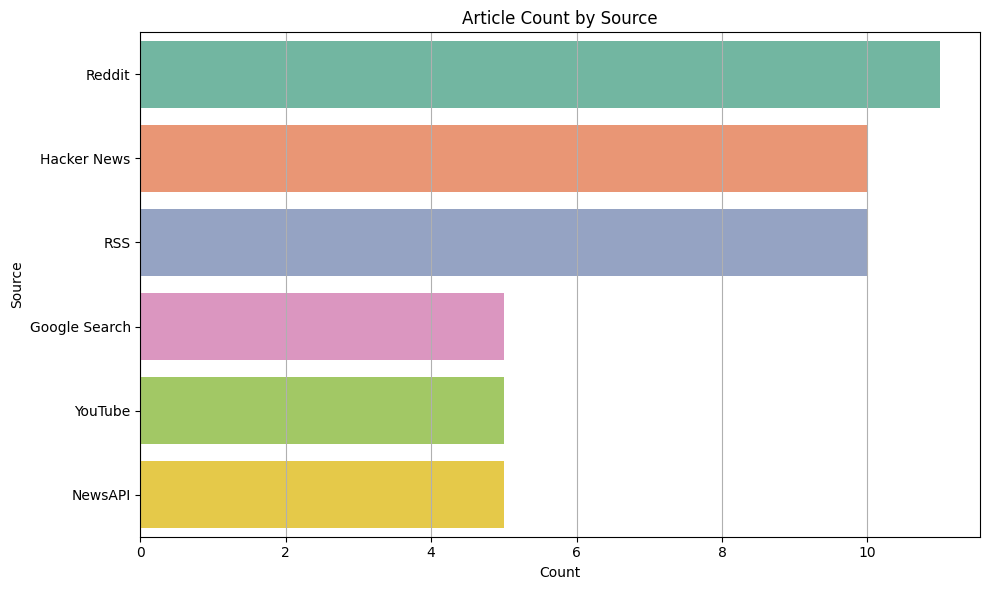

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(data=combined_df, y="source", order=combined_df["source"].value_counts().index, palette="Set2")
plt.title("Article Count by Source")
plt.xlabel("Count")
plt.ylabel("Source")
plt.grid(True, axis="x")
plt.tight_layout()
plt.show()


#### Timeline of Articles (by Published date and source)

/Users/vinothhaldorai/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/vinothhaldorai/opt/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


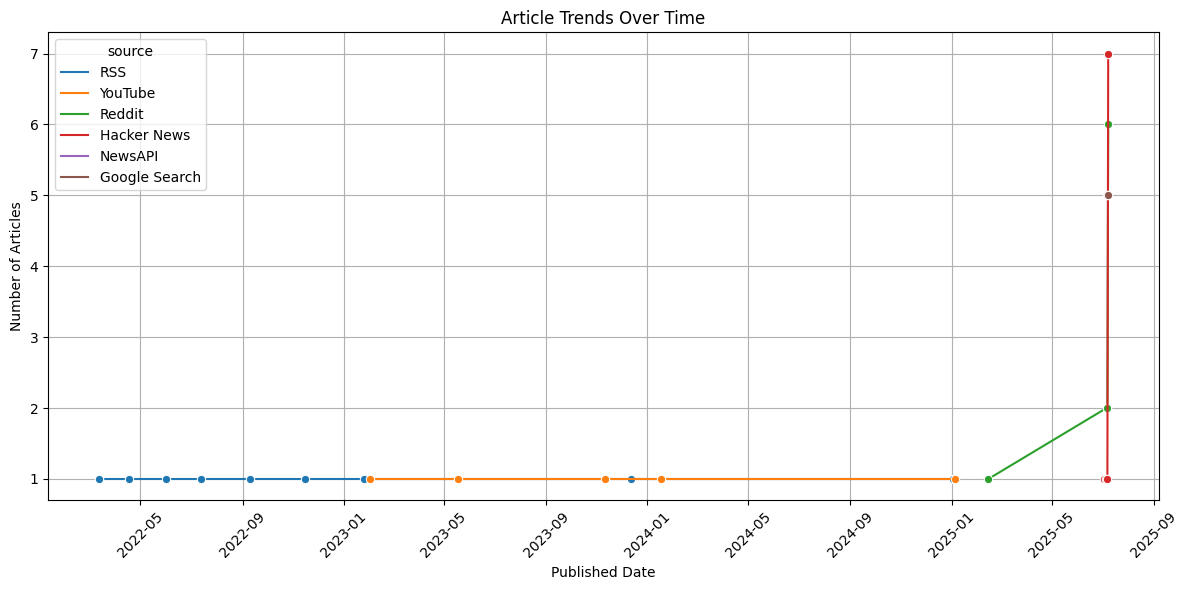

In [25]:
# Convert to date only (drop time)
combined_df["publishedDate"] = combined_df["publishedAt"].dt.date

# Group by date
trend_df = combined_df.groupby(["publishedDate", "source"]).size().reset_index(name="count")

plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_df, x="publishedDate", y="count", hue="source", marker="o")
plt.title("Article Trends Over Time")
plt.xlabel("Published Date")
plt.ylabel("Number of Articles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


In [26]:
#### Timeline of Articles (by Published date)

publishedAt
01-02-2025     1
01-05-2025     1
01-17-2024     1
01-25-2023     1
02-01-2023     1
02-14-2025     1
03-12-2022     1
03-13-2022     1
04-18-2022     1
05-18-2023     1
06-01-2022     1
07-03-2025     1
07-05-2025     1
07-06-2025     2
07-07-2025     8
07-08-2025    18
07-13-2022     1
09-10-2022     1
11-11-2023     1
11-15-2022     1
12-12-2023     1
dtype: int64


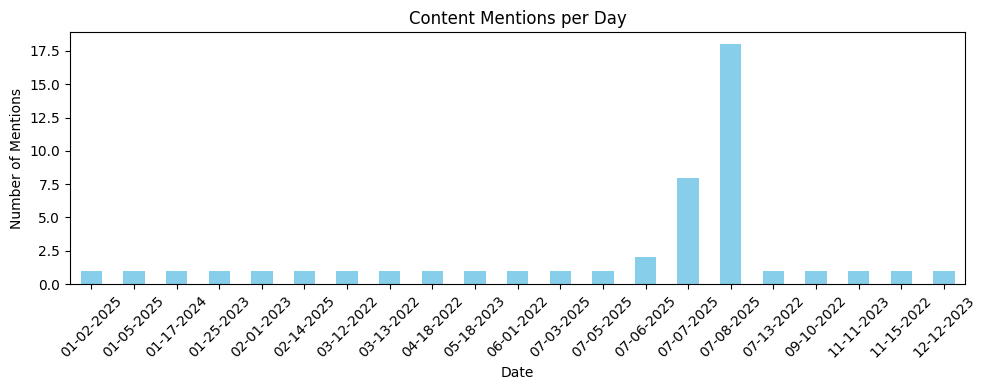

In [27]:

daily_counts = combined_df.groupby(combined_df['publishedAt'].dt.strftime('%m-%d-%Y')).size()

print(daily_counts)

plt.figure(figsize=(10, 4))
daily_counts.plot(kind='bar', color='skyblue')
plt.title("Content Mentions per Day")
plt.xlabel("Date")
plt.ylabel("Number of Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


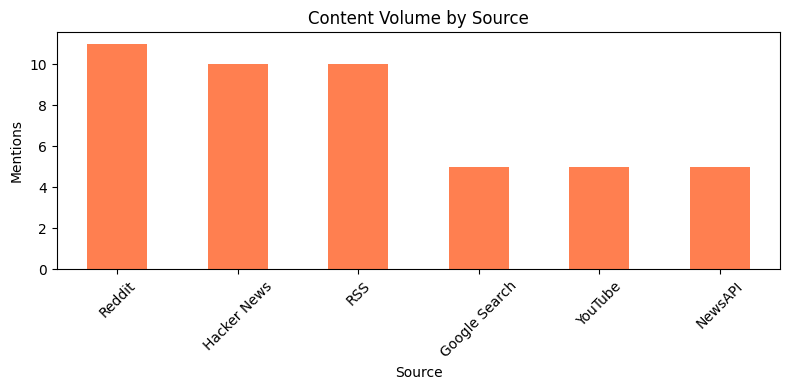

In [28]:
source_counts = combined_df['source'].value_counts()

plt.figure(figsize=(8, 4))
source_counts.plot(kind='bar', color='coral')
plt.title("Content Volume by Source")
plt.xlabel("Source")
plt.ylabel("Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vinothhaldorai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


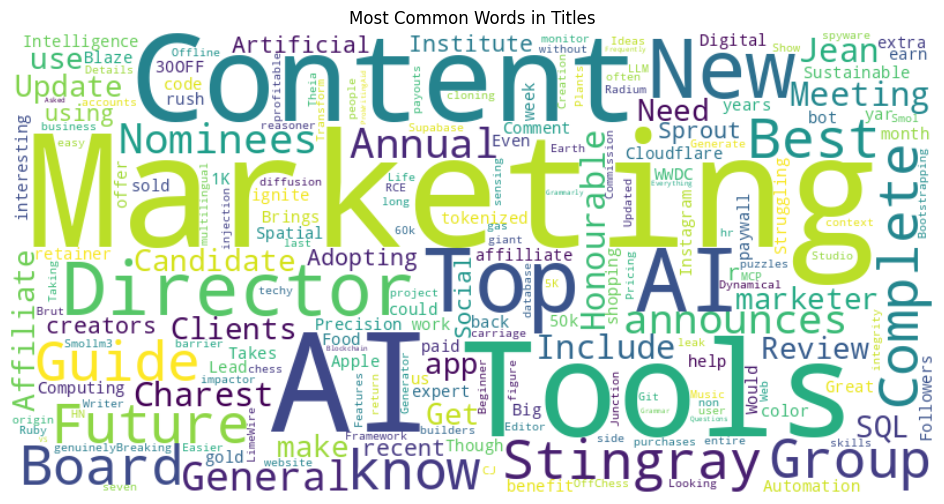

In [29]:
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

text = " ".join(combined_df['title'].dropna().tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=stop_words).generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Titles")
plt.show()


#### Export combined data to CSV and Sqlite for persistent storage

In [30]:
"""
# Create data folder if it doesn't exist
os.makedirs("data", exist_ok=True)

# Export to CSV
combined_df.to_csv("data/combined_data.csv", index=False)
print("Data exported to data/combined_data.csv")
"""

# Define path to root-level "data" directory
data_dir = Path.cwd().parent / "data"
data_dir.mkdir(parents=True, exist_ok=True)

# Export to CSV in root-level data directory
csv_path = data_dir / "combined_data.csv"
combined_df.to_csv(csv_path, index=False)

print(f"Data exported to {csv_path}")


Data exported to /Users/vinothhaldorai/Documents/Vinoth/PROJECTS/content-marketing-agent/data/combined_data.csv


In [31]:
"""
# Connect to (or create) Sqlite database
conn = sqlite3.connect("data/content_data.db")

# Export to table named "Content"
combined_df.to_sql("content", conn, if_exists="replace", index=False)

# Close connection
conn.close()

print("Data exported to Sqlite at data/content_data.db (table: content)")
"""

# Save to SQLite
db_path = data_dir / "content_data.db"

# Connect to (or create) Sqlite database
conn = sqlite3.connect(db_path)

# Export to table named "Content"
combined_df.to_sql("content", conn, if_exists="replace", index=False)

# Close connection
conn.close()

print(f"✅ SQLite DB exported to {db_path}")

✅ SQLite DB exported to /Users/vinothhaldorai/Documents/Vinoth/PROJECTS/content-marketing-agent/data/content_data.db
